# Pair Production


Input:
   * double Z - The charge number of the target atom.
   * double A - The mass number of the target atom.
   * double mass - The projectile rest mass, in GeV
   * double K - The projectile initial kinetic energy.
   * double q - The kinetic energy lost to the photon.
   

Output:
    DCS in m^2/kg.
    
Coefficients for the Gaussian quadrature from:
https://pomax.github.io/bezierinfo/legendre-gauss.html.
 
Theory from https://geant4-userdoc.web.cern.ch/UsersGuides/PhysicsReferenceManual/fo/PhysicsReferenceManual.pdf (Page 151)
        

\begin{equation}
\frac{\text{d}\sigma}{\text{d}\nu}(E, \nu) = \frac{4}{3\pi} \frac{Z(Z + \xi(Z))}{A} N_A {(\alpha r_e)}^{2} (\frac{1 - \nu}{E\nu}) \int_{p}[\Phi_e + (m_e/M_\mu)^{2}\Phi_\mu]dp
\end{equation}

### Define Coefficients for the Gaussian quadrature

In [ ]:
#define N_GQ 8
@njit(double(double,double,double,double,double))
def pair_production(Z, A, mass, K, q):
    N_GQ = 8
    xGQ = [ 0.01985507, 0.10166676, 0.2372338, 0.40828268, 0.59171732, 0.7627662, 0.89833324, 0.98014493 ]
    wGQ = [ 0.05061427, 0.11119052, 0.15685332, 0.18134189, 0.18134189, 0.15685332, 0.11119052, 0.05061427 ]

 

### Check the bounds of the energy transfer.

In [ ]:
    if q <= 4.0 * ELECTRON_MASS:
        return 0.0
    sqrte = 1.6487212707
    Z13 = math.pow(Z, 1. / 3.)
    if q >= K + mass * (1.0 - 0.75 * sqrte * Z13):
        return 0.

### Precompute some constant factors for the integration.

In [ ]:
    nu = q / (K + mass)

In [ ]:
    r = mass / ELECTRON_MASS

\begin{equation}
r = \frac{M_\mu}{m_e}
\end{equation}

In [ ]:
    beta = 0.5 * nu * nu / (1.0 - nu)
        

\begin{equation}
\beta = \frac{\nu^{2}}{2(1 - \nu)}
\end{equation}

In [ ]:
    xi_factor = 0.5 * r * r * beta


\begin{equation}
\text{xi_factor} = \frac{M_\mu ^{2} \nu^{2}}{4m_e^{2}(1 - \nu)}
\end{equation}

In [ ]:
    A = 202.4 if Z == 1.0 else 183.0
    AZ13 = A / Z13

In [ ]:
    cL = 2. * sqrte * ELECTRON_MASS * AZ13

\begin{equation}
cl = 2\sqrt{e} m_e \frac{A}{Z^{1/3}}
\end{equation}

In [ ]:
    cLe = 2.25 * Z13 * Z13 / (r * r)

\begin{equation}
cle = (\frac{3m_e Z^{1/3}}{2M_\mu})^{2}
\end{equation}

###  Compute the bound for the integral.

In [ ]:
    gamma = 1. + K / mass
    x0 = 4.0 * ELECTRON_MASS / q
    x1 = 6.0 / (gamma * (gamma - q / mass))
    argmin = (x0 + 2. * (1. - x0) * x1) / (1. + (1. - x1) * math.sqrt(1. - x0))
    if (argmin >= 1.) or (argmin <= 0.):
        return 0.0
    tmin = math.log(argmin)

### Compute the integral over t = ln(1-rho).

In [ ]:
    I = 0.0
    i = 0
    for i in range(8):
        eps = math.exp(xGQ[i] * tmin)
        rho = 1. - eps
        rho2 = rho * rho
        rho21 = eps * (2. - eps)
        xi = xi_factor * rho21
        xi_i = 1. / xi
        #Compute the e-term. 
        Be = 0.
        if xi >= 1E+03:
            Be = 0.5 * xi_i * ((3 - rho2) + 2. * beta * (1. + rho2))
        else:
            Be = ((2. + rho2) * (1. + beta) + xi * (3. + rho2)) * math.log(1. + xi_i) + (rho21 - beta) / (1. + xi) - 3. - rho2
        Ye = (5. - rho2 + 4. * beta * (1. + rho2)) / (2. * (1. + 3. * beta) * math.log(3. + xi_i) - rho2 - 2. * beta * (2. - rho2))

In [ ]:
        xe = (1. + xi) * (1. + Ye)            

\begin{equation}
xe = (1 + \xi)(1 + Y_e)
\end{equation}

In [ ]:
        cLi = cL / rho21

In [ ]:
        Le = math.log(AZ13 * math.sqrt(xe) * q / (q + cLi * xe)) - 0.5 * math.log(1. + cLe * xe)
                

\begin{equation}
Le = \ln(\frac{A^{*}Z^{-1/3} \sqrt{(1 + \xi)(1 + Y_e)}}{1 + \frac{2m\sqrt{e}A*Z^{-1/3}(1 + \xi)(1 + Y_\mu)}{E\nu(1 - \rho^{2})}})  - \frac{1}{2}ln([1 + (\frac{3mZ^{1/3}}{2\mu})^{2}(1 + \xi)(1 + Y_e)]) = ln(\frac{qA^{*}Z^{-1/3}\sqrt{xe}}{q + cli*xe}) - \frac{1}{2}ln([1 + cle*xe])
\end{equation}

In [ ]:
        Phi_e = Be * Le
        if Phi_e < 0.:
            Phi_e = 0.

### Compute the mu-term.

In [ ]:
        Bmu = 0.
        if xi <= 1E-03:
            Bmu = 0.5 * xi * (5. - rho2 + beta * (3. + rho2))
        else:
            Bmu = ((1. + rho2) * (1. + 1.5 * beta) - xi_i * (1. + 2. * beta) * rho21) * math.log(1. + xi) + xi * (rho21 - beta) / (1. + xi) + (1. + 2. * beta) * rho21
        Ymu = (4. + rho2 + 3. * beta * (1. + rho2)) / ((1. + rho2) * (1.5 + 2. * beta) * math.log(3. + xi) + 1. - 1.5 * rho2)
        xmu = (1. + xi) * (1. + Ymu)

In [ ]:
        Lmu = math.log(r * AZ13 * q / (1.5 * Z13 * (q + cLi * xmu)))

\begin{equation}
L_\mu = \ln(\frac{(\frac{M_\mu}{m_e})A^{*}Z^{-1/3} \sqrt{(1 + \frac{1}{\xi})(1 + Y_e)}}{1 + \frac{2m\sqrt{e}A*Z^{-1/3}(1 + \xi)(1 + Y_\mu)}{E\nu(1 - \rho^{2})}})  - ln(\frac{3}{2} Z^{1/3}\sqrt{(1 + \frac{1}{\xi})(1 + Y_\mu)})
\end{equation}

In [ ]:
        Phi_mu = Bmu * Lmu
        if Phi_mu < 0.:
            Phi_mu = 0.
        # Update the t-integral.
        I -= (Phi_e + Phi_mu / (r * r)) * (1. - rho) * wGQ[i] * tmin

### Atomic electrons form factor.
ζ(Z) ≈ 1 takes into account the pair production in collisions with
electrons. 

In [ ]:
    zeta = 0.
    if gamma <= 35.:
        zeta = 0.
    else:
        gamma1 = 0.
        gamma2 = 0.
        if Z == 1.:
            gamma1 = 4.4E-05
            gamma2 = 4.8E-05
        else:
            gamma1 = 1.95E-05
            gamma2 = 5.30E-05
        zeta = 0.073 * math.log(gamma / (1. + gamma1 * gamma * Z13 * Z13)) - 0.26
        if zeta <= 0.:
            zeta = 0.
        else:
            zeta /= 0.058 * math.log(gamma / (1. + gamma2 * gamma * Z13)) - 0.14

### Gather the results and return the macroscopic DCS.

The full muon's energy


In [ ]:
    E = K + mass

In [ ]:
    dcs = 1.794664E-34 * Z * (Z + zeta) * (E - q) * I / (q * E)

\begin{equation}
\Phi_{e,\mu} = B_{e,\mu} {L_{e,\mu}}^{'}
\end{equation}

\begin{equation}
\Phi_{e,\mu} = 0 \text{  whenever  } \Phi_{e,\mu}<0
\end{equation}

$B_e$ and $B_\mu$ do not depend on Z, A, and are given by

\begin{equation}
B_e = [(2 + \rho^{2})(1 + \beta) + \xi(3 + \rho^{2})]\ln(1 + \frac{1}{\xi}) + \frac{1 - \rho^{2} - \beta}{1 + \xi} - (3 + \rho^{2})
\approx \frac{1}{2\xi}[(3 - \rho^{2}) + 2\beta(z + \rho^{2})] \text{ for } \xi \geq 10 ^{3}
\end{equation}

\begin{equation}
B_\mu = [(1 + \rho^{2})(1 + \frac{3\beta}{2}) - \frac{1}{\xi}(1 + 2\beta)(1 - \rho^{2})]\ln(1 + \xi) + \frac{\xi(1 - \rho{2} - \beta)}{1 + \xi} + (1 + 2\beta)(1 - \rho^{2})
\approx \frac{\xi}{2}[(5 - \rho^{2}) + \beta(3 + \rho^{2})] \text{ for } \xi \leq 10^{-3}
\end{equation}

Also,


\begin{equation}
\xi = \frac{\mu^{2}\nu^{2}}{4m^{2}} \frac{(1 - \rho^{2})}{1 - \nu}; \text{ }
\beta = \frac{\nu^{2}}{2(1 - \nu)}
\end{equation}


\begin{equation}
\nu = \frac{q}{E}
\end{equation}

In [ ]:
    return 0 if dcs < 0. else dcs * 1E+03 * AVOGADRO_NUMBER * (mass + K) / A

### Example of using

For example take Kinetic Energy (K) is equal to 1. And take recoil energi in range from 5% to 100% of K.

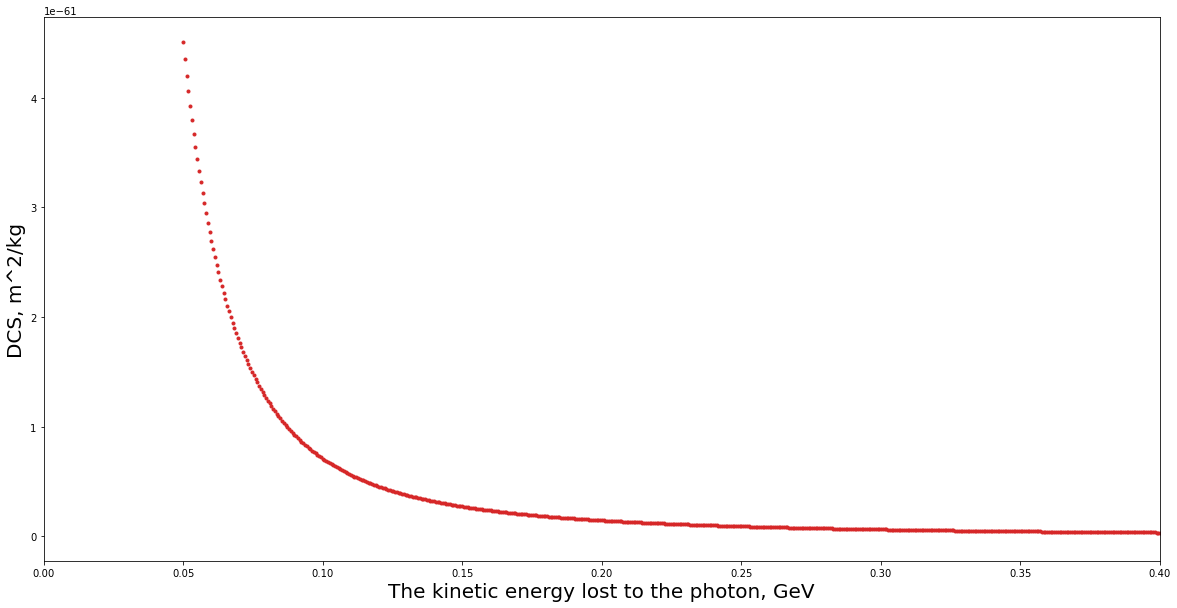

In [2]:
from constants import ELECTRON_MASS
from constants import AVOGADRO_NUMBER
import math
from numba import njit, double, int32


'''
The default Bremsstrahlung differential cross section.
  @param Z       The charge number of the target atom.
  @param A       The mass number of the target atom.
  @param mu      The projectile rest mass, in GeV
  @param K       The projectile initial kinetic energy.
  @param q       The kinetic energy lost to the photon.
  @return The corresponding value of the atomic DCS, in m^2 / GeV.
The differential cross section is computed following R.P. Kokoulin's formulae taken from the Geant4 Physics Reference Manual. '''
#@njit(double(double,double,double,double), locals={'N_GQ':int32,'xGQ':double[:],'wGQ':double[:],'sqrte':double,'Z13':double,'nu':double,'r':double,'beta':double,'xi_factor':double,'A':double, 'AZ13':double,'cL':double,'cLe':double,'gamma':double,'x0':double,'x1':double,'argmin':double,'tmin':double,'I':double,'i':int32,'eps':double,'rh':double,'rho2':double,'rho21':double,'xi':double,'xi_i':double,'Be':double,'Ye':double,'xe':double,'cLi':double,'Le':double,'Phi_e':double,'Bmu':double,'Ymu':double,'xmu':double,'Lmu':double,'Phi_m':double,'zeta':double,'gamma1':double,'gamma2':double,'E':double,'dcs':double})
@njit(double(double,double,double,double,double))
def pair_production(Z, A, mass, K, q):
    '''
    Coefficients for the Gaussian quadrature from:
    https://pomax.github.io/bezierinfo/legendre-gauss.html.
    '''
    N_GQ = 8
    xGQ = [ 0.01985507, 0.10166676, 0.2372338, 0.40828268, 0.59171732, 0.7627662, 0.89833324, 0.98014493 ]
    wGQ = [ 0.05061427, 0.11119052, 0.15685332, 0.18134189, 0.18134189, 0.15685332, 0.11119052, 0.05061427 ]
    # Check the bounds of the energy transfer.
    if q <= 4.0 * ELECTRON_MASS:
        return 0.0
    sqrte = 1.6487212707
    Z13 = math.pow(Z, 1. / 3.)
    if q >= K + mass * (1.0 - 0.75 * sqrte * Z13):
        return 0.
    # Precompute some constant factors for the integration.
    nu = q / (K + mass)
    r = mass / ELECTRON_MASS
    beta = 0.5 * nu * nu / (1.0 - nu)
    xi_factor = 0.5 * r * r * beta
    A = 202.4 if Z == 1.0 else 183.0
    AZ13 = A / Z13
    cL = 2. * sqrte * ELECTRON_MASS * AZ13
    cLe = 2.25 * Z13 * Z13 / (r * r)
    # Compute the bound for the integral.
    gamma = 1. + K / mass
    x0 = 4.0 * ELECTRON_MASS / q
    x1 = 6.0 / (gamma * (gamma - q / mass))
    argmin = (x0 + 2. * (1. - x0) * x1) / (1. + (1. - x1) * math.sqrt(1. - x0))
    if (argmin >= 1.) or (argmin <= 0.):
        return 0.0
    tmin = math.log(argmin)
    # Compute the integral over t = ln(1-rho).
    I = 0.0
    i = 0
    for i in range(8):
        eps = math.exp(xGQ[i] * tmin)
        rho = 1. - eps
        rho2 = rho * rho
        rho21 = eps * (2. - eps)
        xi = xi_factor * rho21
        xi_i = 1. / xi
        #Compute the e-term. 
        Be = 0.
        if xi >= 1E+03:
            Be = 0.5 * xi_i * ((3 - rho2) + 2. * beta * (1. + rho2))
        else:
            Be = ((2. + rho2) * (1. + beta) + xi * (3. + rho2)) * math.log(1. + xi_i) + (rho21 - beta) / (1. + xi) - 3. - rho2
        Ye = (5. - rho2 + 4. * beta * (1. + rho2)) / (2. * (1. + 3. * beta) * math.log(3. + xi_i) - rho2 - 2. * beta * (2. - rho2))
        xe = (1. + xi) * (1. + Ye)
        cLi = cL / rho21
        Le = math.log(AZ13 * math.sqrt(xe) * q / (q + cLi * xe)) - 0.5 * math.log(1. + cLe * xe)
        Phi_e = Be * Le
        if Phi_e < 0.:
            Phi_e = 0.
        # Compute the mu-term.
        Bmu = 0.
        if xi <= 1E-03:
            Bmu = 0.5 * xi * (5. - rho2 + beta * (3. + rho2))
        else:
            Bmu = ((1. + rho2) * (1. + 1.5 * beta) - xi_i * (1. + 2. * beta) * rho21) * math.log(1. + xi) + xi * (rho21 - beta) / (1. + xi) + (1. + 2. * beta) * rho21
        Ymu = (4. + rho2 + 3. * beta * (1. + rho2)) / ((1. + rho2) * (1.5 + 2. * beta) * math.log(3. + xi) + 1. - 1.5 * rho2)
        xmu = (1. + xi) * (1. + Ymu)
        Lmu = math.log(r * AZ13 * q / (1.5 * Z13 * (q + cLi * xmu)))
        Phi_mu = Bmu * Lmu
        if Phi_mu < 0.:
            Phi_mu = 0.
        # Update the t-integral.
        I -= (Phi_e + Phi_mu / (r * r)) * (1. - rho) * wGQ[i] * tmin
    # Atomic electrons form factor.
    zeta = 0.
    if gamma <= 35.:
        zeta = 0.
    else:
        gamma1 = 0.
        gamma2 = 0.
        if Z == 1.:
            gamma1 = 4.4E-05
            gamma2 = 4.8E-05
        else:
            gamma1 = 1.95E-05
            gamma2 = 5.30E-05
        zeta = 0.073 * math.log(gamma / (1. + gamma1 * gamma * Z13 * Z13)) - 0.26
        if zeta <= 0.:
            zeta = 0.
        else:
            zeta /= 0.058 * math.log(gamma / (1. + gamma2 * gamma * Z13)) - 0.14
    # Gather the results and return the macroscopic DCS.
    E = K + mass
    dcs = 1.794664E-34 * Z * (Z + zeta) * (E - q) * I / (q * E)
    return 0 if dcs < 0. else dcs * 1E+03 * AVOGADRO_NUMBER * (mass + K) / A

import numpy as np
import matplotlib.pyplot as plt
E = 2
sample = 1500
X = []
Y = []
for i in range(sample):
    x = 0.05 + i*(1 - 0.05)/sample;
    y = pair_production(11, 22, 0.10565839, 1, x)
    X.append(x)
    Y.append(y)
    

fig, ax = plt.subplots()
ax.plot(X, Y, '.C3')    
plt.xlim([0.,0.4])

ax.set_xlabel('The kinetic energy lost to the photon, GeV', fontsize = 20)
ax.set_ylabel('DCS, m^2/kg', fontsize = 20)

fig.set_figwidth(20)
fig.set_figheight(10)
    
plt.show()   